##Visualizing Sales Performance Data

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum as _sum, avg, when, round
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType, DateType
from datetime import date

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os


In [2]:
# Spark session (if running locally)
spark = SparkSession.builder.appName("SalesViz").getOrCreate()

# Create DBFS output folder
output_dir = "/dbfs/FileStore/tables/sales_viz/"
os.makedirs(output_dir, exist_ok=True)


In [4]:
# Schema & inline data
schema = StructType([
    StructField("order_id", StringType()),
    StructField("region", StringType()),
    StructField("category", StringType()),
    StructField("quantity", IntegerType()),
    StructField("price", DoubleType()),
    StructField("order_date", DateType())
])

data = [
    ("O001", "South", "Electronics", 3, 15000.0, date(2025, 1, 5)),
    ("O002", "North", "Clothing", 5, 2000.0, date(2025, 1, 6)),
    ("O003", "East", "Furniture", 2, 12000.0, date(2025, 1, 7)),
    ("O004", "West", "Electronics", 1, 18000.0, date(2025, 1, 8)),
    ("O005", "North", "Furniture", 4, 9000.0, date(2025, 1, 10)),
    ("O006", "South", "Clothing", 6, 2500.0, date(2025, 1, 11)),
    ("O007", "East", "Electronics", 2, 17000.0, date(2025, 1, 12)),
    ("O008", "South", "Furniture", 5, 8500.0, date(2025, 1, 15)),
    ("O009", "West", "Clothing", 7, 3000.0, date(2025, 1, 17)),
    ("O010", "North", "Electronics", 4, 16000.0, date(2025, 1, 18))
]

df = spark.createDataFrame(data, schema)

# 1. Show first 10 rows

In [5]:
df.show(10, truncate=False)

+--------+------+-----------+--------+-------+----------+
|order_id|region|category   |quantity|price  |order_date|
+--------+------+-----------+--------+-------+----------+
|O001    |South |Electronics|3       |15000.0|2025-01-05|
|O002    |North |Clothing   |5       |2000.0 |2025-01-06|
|O003    |East  |Furniture  |2       |12000.0|2025-01-07|
|O004    |West  |Electronics|1       |18000.0|2025-01-08|
|O005    |North |Furniture  |4       |9000.0 |2025-01-10|
|O006    |South |Clothing   |6       |2500.0 |2025-01-11|
|O007    |East  |Electronics|2       |17000.0|2025-01-12|
|O008    |South |Furniture  |5       |8500.0 |2025-01-15|
|O009    |West  |Clothing   |7       |3000.0 |2025-01-17|
|O010    |North |Electronics|4       |16000.0|2025-01-18|
+--------+------+-----------+--------+-------+----------+



# 2. Create revenue column

In [7]:
df = df.withColumn("revenue", col("quantity") * col("price"))

# Convert to Pandas for plotting


In [8]:
pdf = df.toPandas()

# 3. Bar chart: Total revenue by category

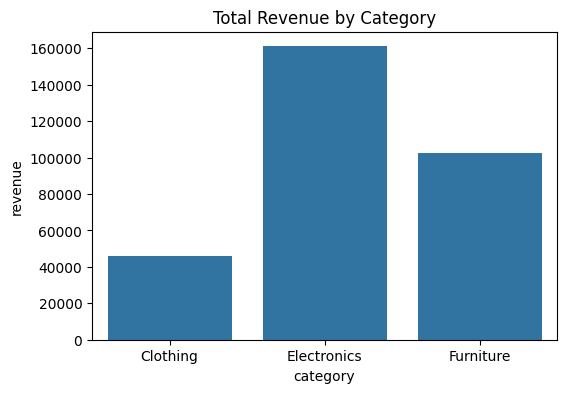

In [9]:
rev_by_cat = pdf.groupby("category")["revenue"].sum().reset_index()
plt.figure(figsize=(6,4))
sns.barplot(x="category", y="revenue", data=rev_by_cat)
plt.title("Total Revenue by Category")
plt.savefig(output_dir + "revenue_by_category.png")

# 4. Line chart: Revenue trend by order_date

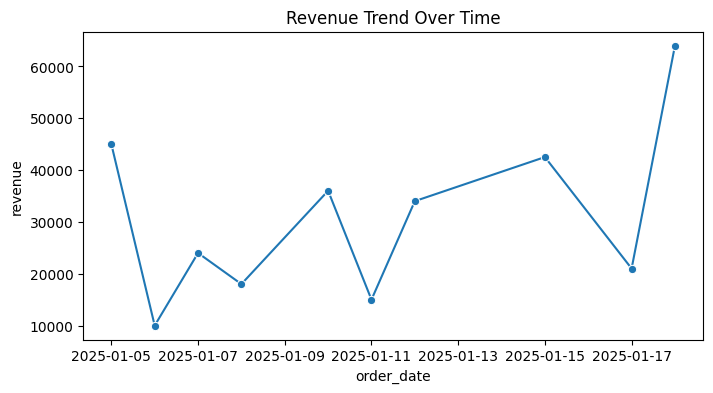

In [10]:
rev_by_date = pdf.groupby("order_date")["revenue"].sum().reset_index()
rev_by_date = rev_by_date.sort_values("order_date")
plt.figure(figsize=(8,4))
sns.lineplot(x="order_date", y="revenue", data=rev_by_date, marker="o")
plt.title("Revenue Trend Over Time")
plt.savefig(output_dir + "revenue_trend.png")

# 5. Pie chart: Revenue % by region

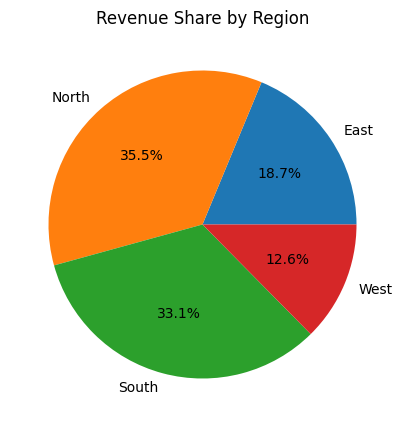

In [11]:
rev_by_region = pdf.groupby("region")["revenue"].sum()
plt.figure(figsize=(5,5))
rev_by_region.plot.pie(autopct="%1.1f%%")
plt.title("Revenue Share by Region")
plt.ylabel("")
plt.savefig(output_dir + "revenue_by_region_pie.png")

# 6. Stacked bar: Quantity per category by region

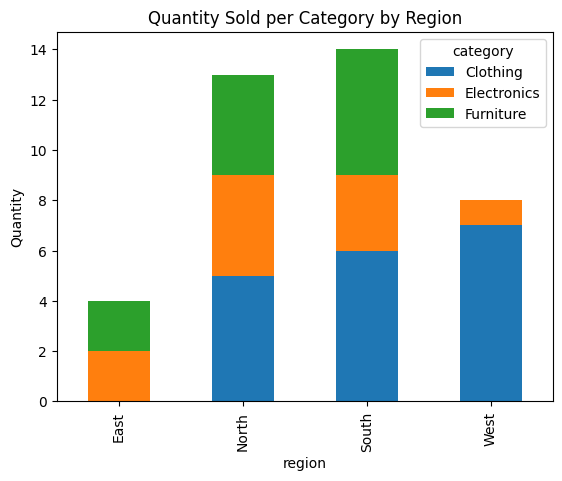

In [12]:
qty_cat_region = pdf.groupby(["region","category"])["quantity"].sum().unstack(fill_value=0)
qty_cat_region.plot(kind="bar", stacked=True)
plt.title("Quantity Sold per Category by Region")
plt.ylabel("Quantity")
plt.savefig(output_dir + "stacked_qty_cat_region.png")

# 7. Top 5 products by revenue

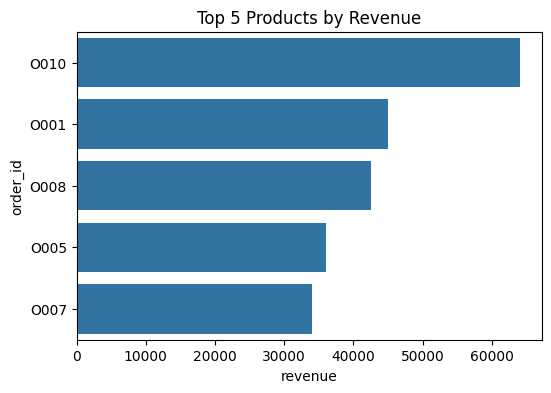

In [13]:
top5 = pdf.sort_values("revenue", ascending=False).head(5)
plt.figure(figsize=(6,4))
sns.barplot(x="revenue", y="order_id", data=top5, orient="h")
plt.title("Top 5 Products by Revenue")
plt.savefig(output_dir + "top5_products.png")

# 8. Scatter plot: Quantity vs Price colored by category

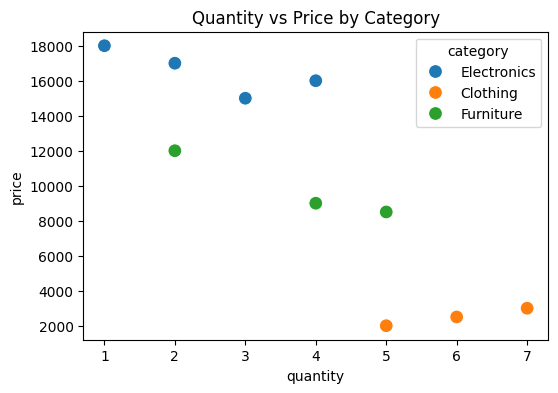

In [14]:
plt.figure(figsize=(6,4))
sns.scatterplot(x="quantity", y="price", hue="category", data=pdf, s=100)
plt.title("Quantity vs Price by Category")
plt.savefig(output_dir + "scatter_qty_price.png")

# 9. Avg order value by region

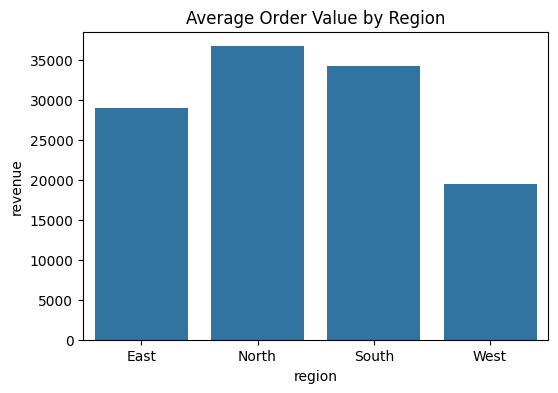

In [15]:
avg_order_val = pdf.groupby("region")["revenue"].mean().reset_index()
plt.figure(figsize=(6,4))
sns.barplot(x="region", y="revenue", data=avg_order_val)
plt.title("Average Order Value by Region")
plt.savefig(output_dir + "avg_order_value.png")

# 10. Heatmap: Revenue by region & category

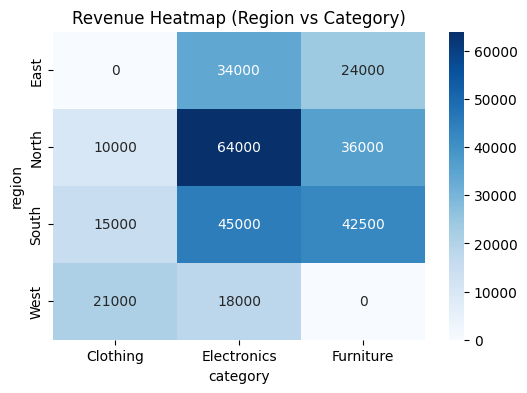

In [16]:
pivot_rev = pdf.pivot_table(values="revenue", index="region", columns="category", aggfunc="sum", fill_value=0)
plt.figure(figsize=(6,4))
sns.heatmap(pivot_rev, annot=True, fmt=".0f", cmap="Blues")
plt.title("Revenue Heatmap (Region vs Category)")
plt.savefig(output_dir + "heatmap_region_category.png")

# 11. Bonus: Discounted revenue

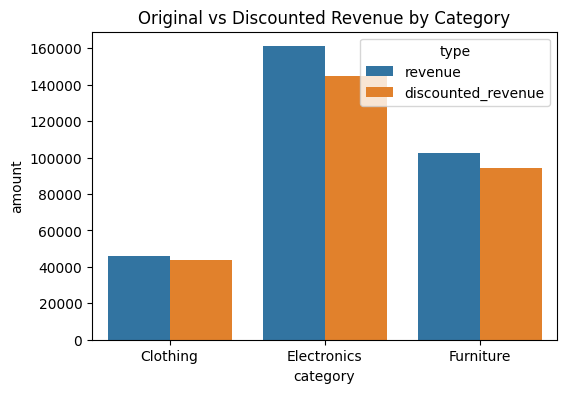

In [17]:
discount_map = {"Electronics": 0.10, "Clothing": 0.05, "Furniture": 0.08}
pdf["discount"] = pdf["category"].map(discount_map)
pdf["discounted_revenue"] = pdf["revenue"] * (1 - pdf["discount"])
rev_compare = pdf.groupby("category")[["revenue","discounted_revenue"]].sum().reset_index()
rev_compare_melt = rev_compare.melt(id_vars="category", value_vars=["revenue","discounted_revenue"], var_name="type", value_name="amount")
plt.figure(figsize=(6,4))
sns.barplot(x="category", y="amount", hue="type", data=rev_compare_melt)
plt.title("Original vs Discounted Revenue by Category")
plt.savefig(output_dir + "discounted_vs_original.png")

# 12. Done — all saved

In [18]:
print(f"Visualizations saved in {output_dir}")

Visualizations saved in /dbfs/FileStore/tables/sales_viz/
